# 2D Case

# The target system

System :  
$\dot x = A 
\begin{bmatrix} \theta \\ \dot\theta \end{bmatrix}$ ,  
$\theta \in \mathbb{R}^2, \dot\theta \in \mathbb{R}^2$, 
$A = \begin{bmatrix} 
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1 \\ 
0 & 0 & 0 & 0 \\ 
0 & 0 & 0 & 0
 \end{bmatrix}$ (Approximation via ignoring 2nd order derivative)

Observable :  
$y = \phi(t) \theta(t)$ 
$= \phi(t)
\begin{bmatrix} 
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 
\end{bmatrix}
x$

True $\theta$ :  <br>
*    $\theta = [2+\sin(t), 3+\cos(0.5t)]^T$


Regressor $\phi(t)$: <br> 

* for t < 10   <br> 
    $\phi = [3  \sin ( \phi_{freq} t), 2.5]$ , <br> 
* for t \geq 10  <br> 
    $\phi = [3  \sin ( \phi_{freq} t), 2.5 \sin (\phi_{freq} t)]$ ,   <br> 
(Default $\phi_{freq}= 4\pi$)



# Kalman filter 

Standard Kalman filter process :  
* $ \dot x = A  x + K (y - \hat y) $

Kalman Gain renewal :  
Define 
$C = \begin{bmatrix}
\phi_1 & 0 & 0 & 0 \\
0      & \phi_2 & 0 & 0
\end{bmatrix}$   

P0 = np.eye(4)  # Initial error covariance  
Q = 0.1 np.eye(4)


S = C @ P @ C.T + R * np.eye(2)  
K = P @ C.T @ np.linalg.inv(S)  
dPdt = A @ P + P @ A.T - K @ C @ P + Q

# integral filter construction? 
$y(t) = [\phi_1(t), \phi_2(t), 0, 0 ] x(t) $, $x=\begin{bmatrix} \theta \\ \dot \theta \end{bmatrix}$  
Let,  
 $\omega \equiv [\phi_1(t), \phi_2(t), 0, 0 ]$,  
Then,   
* $\omega_f (t) = \int_{t_i}^t \exp(-\beta (\tau - ti)) \omega^T(\tau) \omega(\tau) d\tau$  
* $y_f (t) = \int_{t_i}^t \exp(-\beta (\tau - ti)) \omega^T(\tau) y(\tau) d\tau$  
* $\epsilon_f (t) = \int_{t_i}^t \exp(-\beta (\tau - ti)) \omega^T(\tau) \epsilon(\tau) d\tau$  

$y_f(t) = \omega_f(t) + \epsilon_f(t)$

For $\Omega(t) \equiv \det(\omega_f)$,  
$\bar \Upsilon = \Omega(t) x + \bar \mu$ ,   

where,  
        $\bar \Upsilon(t) = adj ( \omega_f(t) ) y_f $  
        $\bar \mu(t) = adj ( \omega_f(t) ) \mu $  

After reduction only taing first 2 dim / 2 x 2 dim, we get  
$\Upsilon = \Omega(t) x + \mu$

What is Kalman gain in this case 
* $ \dot x = A  x + K_{f} (\Upsilon - \Omega(t) \hat x) $

* $C_f = \begin{bmatrix}\det (\omega_f) & 0 & 0 & 0 \\ 0 & \det(\omega_f ) & 0 & 0 \end{bmatrix} $

S = Cf @ P @ Cf.T + R * np.eye(2)  
K = P @ Cf.T @ np.linalg.inv(S)  
dPdt = A @ P + P @ A.T - K @ Cf @ P + Q

In [1]:
import sys
sys.path.append('Cpp_lib')
import adjugate_module
def compute_adjugate_pybind11(matrix):
    # this use cpp module under Cpp_lib directory
    adjugate_matrix = adjugate_module.compute_adjugate(matrix)
    return adjugate_matrix


In [50]:
import pickle

def save_sol(sol, dir_name):
    with open(dir_name + '/sol.pickle', mode='wb') as f:
        pickle.dump(sol, f)

def read_sol(dir_name):
    with open(dir_name + '/sol.pickle', mode='rb') as f:
        sol = pickle.load(f)
    return sol



def generate_dir(phi_freq_coeff, Rnoise, det_omega_f_thresh):
    base_path = 'result/PHI_FREQ_COEFF_' + str(phi_freq_coeff) + '/'
    dir_name = base_path + 'NOISEVAR_' + str(Rnoise) + '_OMEGA_THRE_' + str(det_omega_f_thresh)
    return dir_name

# Piece-wise constant noise

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

def piecewise_constant_white_noise_generator(total_time, interval_duration, noise_variance):
    # Calculate number of intervals
    num_intervals = int(total_time / interval_duration)
    
    # Generate white noise
    white_noise = np.random.normal(scale=np.sqrt(noise_variance), size=num_intervals)
    
    # Create time vector
    t_values = np.arange(0, total_time, interval_duration)
    
    # Create piecewise constant function
    def piecewise_constant_noise(t):
        # Find the interval index for time t
        interval_index = int(t // interval_duration)
        
        # Return the corresponding white noise value
        if interval_index < num_intervals:
            return white_noise[interval_index]
        else:
            return 0.0  # Default to 0 outside of defined intervals
    
    return piecewise_constant_noise

# Example usage:
total_time = 1000
interval_duration = 1
noise_variance = 1.0

# Generate piecewise constant white noise function
noise_function = piecewise_constant_white_noise_generator(total_time, interval_duration, noise_variance)

# Evaluate the function at specific times
times_to_evaluate = [0.5, 0.55, 1.3, 2.7, 4.2, 6.8, 9.5]
for t in times_to_evaluate:
    print(f"Noise at time {t}: {noise_function(t)}")

Noise at time 0.5: -1.5767167381218683
Noise at time 0.55: -1.5767167381218683
Noise at time 1.3: 0.7185011268486822
Noise at time 2.7: 0.7074462941821623
Noise at time 4.2: 0.4114838619726433
Noise at time 6.8: -0.9141493864880174
Noise at time 9.5: -0.9544297628029277


In [52]:


import numpy as np
from scipy.integrate import solve_ivp
import scipy
import matplotlib.pyplot as plt


SWITCHTIME = 30

def compute_phi(t):
    if t < SWITCHTIME:
        phi = np.array([3 * np.sin(phi_freq * t), 2.5])
    else:
        phi = np.array([3 * np.sin(phi_freq * t), 2.5 * np.sin(phi_freq * t)])
    return phi

def measurement_matrix(t, det_omega=None):

    if det_omega == None:
        
        phi = compute_phi(t)
        C = np.zeros((2, 4))
        C[0, 0] = phi[0]
        C[1, 1] = phi[1]
        return C
     
    elif np.isfinite(det_omega) :
        Cf = np.zeros((2, 4))
        Cf[0, 0] = det_omega
        Cf[1, 1] = det_omega
        return Cf





def true_signal(t, switch_flg=True):

    if switch_flg == False:
        theta = np.array([2 + np.sin(t),
                 3 + np.cos(0.5 * t)])
    else:

        tindex =  (t%40) >= 20
        gap = 3
        theta = np.array([2 + np.sin(t) + gap * tindex,
               3 + np.cos(0.5 * t) + gap * tindex])
 

    return theta





def kalman_filter(t, y, gamma = 1):


    x = y[:x_dim]
    P = y[x_dim:x_dim+p_dim].reshape(n, n)
    # these are integrated results
    omega_f =   y[x_dim+p_dim            :         x_dim+p_dim+omega_f_dim        ].reshape(filter_dim,filter_dim)
    y_f =       y[x_dim+p_dim+omega_f_dim:         x_dim+p_dim+omega_f_dim+y_f_dim]

    epsilon_f = y[x_dim+p_dim+omega_f_dim+y_f_dim: x_dim+p_dim+omega_f_dim+y_f_dim+epsilon_f_dim]
    
    C = measurement_matrix(t)
    
   
    obs = measurement_matrix(t) @  (np.concatenate((np.array(true_signal(t)), np.array([ 0, 0]) )) ) # + Qnoise @ np.random.normal(0, 1, size=(4)) )   # true_signal(t)
    # add noise to measurement
    obs = obs + noise_function(t)   # Rnoise * np.random.normal(0, 5, size=(1)) 
    obs = obs.reshape(-1, 1)  # has dimension 2

    # System dynamics
    adj_omega_f =  compute_adjugate_pybind11(omega_f)
    det_omega_f = scipy.linalg.det(omega_f)
    # print(det_omega_f)

    if det_omega_f < det_omega_f_thresh:
        # switch dynamics depending on the adjugate computation result omega(t)<kappa
        # Kalman Gain
        S = C @ P @ C.T + R * np.eye(2)
        K = P @ C.T @ np.linalg.inv(S)

        dxdt = A @ x + gamma * K @ ( obs - C@x ) # No measurement update in differential equation
        dPdt = A @ P + P @ A.T - K @ C @ P + Q

    else:
        if 0: # Kalman Gain
            C_f = measurement_matrix(t, det_omega_f)
            S = C_f @ P @ C_f.T + R * np.eye(2)
            Kf = P @ C_f.T @ np.linalg.inv(S)
            dxdt = A @ x + gamma * Kf @ ( adj_omega_f@y_f - det_omega_f * x[:2] ) # No measurement update in differential equation
            dPdt = A @ P + P @ A.T - Kf @ C_f @ P + Q

        else: # I-DREM
            gamma_0 = 1000
            dxdt = np.concatenate([- gamma_0 / det_omega_f * ( det_omega_f * x[:2]  - adj_omega_f @ y_f ), [[0], [0]] ], axis=0)
            dPdt = np.zeros_like(Q)  # A @ P + P @ A.T - Kf @ C_f @ P + Q



    # current time index
    ti = T * np.floor((t - t0)/T)

    domega_fdt   =  np.exp(- beta * (t-ti)) * measurement_matrix(t)[:filter_dim, :filter_dim].T @ measurement_matrix(t)[:filter_dim, :filter_dim]
    dy_fdt       =  np.exp(- beta * (t-ti)) * measurement_matrix(t)[:filter_dim, :filter_dim].T @ obs
    #depsilon_fdt = np.exp(- beta * (t-ti)) * 
    
    return np.concatenate([dxdt, dPdt.flatten().reshape(-1,1), domega_fdt.flatten().reshape(-1,1), dy_fdt.reshape(-1,1), epsilon_f.reshape(-1,1)], axis=0)





In [99]:



# Constants
Q = 0.2 * np.eye(4)  # Process noise covariance (adapt size to state vector)
R = 1e-0   # Measurement noise covariance (scalar, assuming y is scalar)

# real noise 
Qnoise = Q*1.0  # Process noise covariance (adapt size to state vector)


# State-space matrices
A = np.array([[0, 0, 1, 0], 
              [0, 0, 0, 1], 
              [0, 0, 0, 0], 
              [0, 0, 0, 0]])  # Dynamics matrix

# dimension 
n = 4
x_dim = n
p_dim = n*n


filter_dim = 2
omega_f_dim = (filter_dim)*(filter_dim)
y_f_dim = filter_dim
epsilon_f_dim = filter_dim

# Time settings
t0, tf = 0, 60  # Start and end times
sample_hz = 100
Neval = (tf-t0) * sample_hz + 1
t_eval = np.linspace(t0, tf, Neval)  # Time points to evaluate

# define signal phi frequency
phi_freq_coeff = 1
phi_freq = phi_freq_coeff * np.pi

Rnoise_list =  [R*0.2, R*0.5, R*1.0, R*2.0, R*3.0]
#det_omega_f_thresh_list = [0.000001, 0.001, 0.01,  0.1, 0.5, 1.0, 1.5, np.infty ]
#det_omega_f_thresh_list = [ 0.001, 0.01]
det_omega_f_thresh_list = [ 2.0, 3.0]
# Rnoise_list =  [R*0.2]
# det_omega_f_thresh_list = [np.infty ]

In [73]:
###### Analysis ######
# Prepare a single sol object that mimics the output of solve_ivp over the full interval
class Sol:
    def __init__(self, t, y, x_dim):
        self.t = t
        self.y = y
        self.x_dim = x_dim

    def fetch_est(self):
        x_est = self.y[:self.x_dim].T
        theta1, theta2, theta_dot1, theta_dot2 = x_est[:, 0], x_est[:, 1], x_est[:, 2], x_est[:, 3]
        return theta1, theta2, theta_dot1, theta_dot2 

det_omega_f_thre: 2.0
Rnoise: 0.2


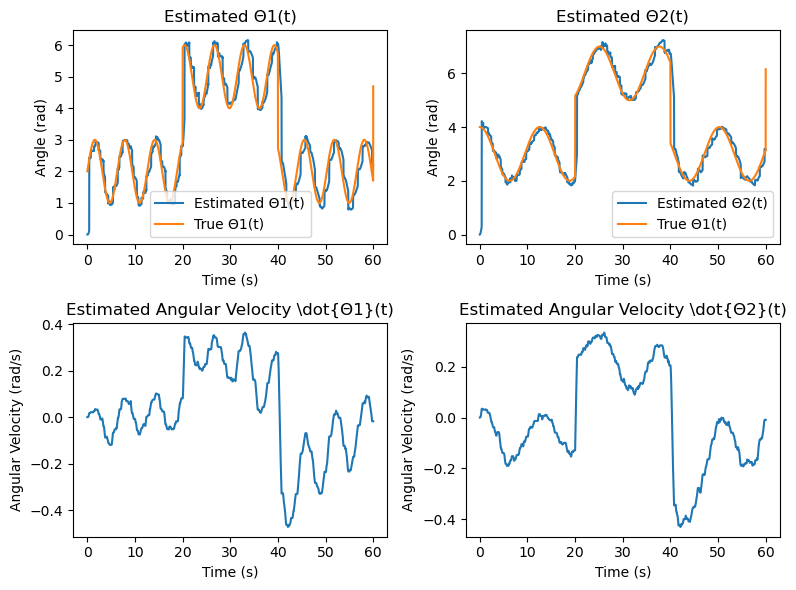

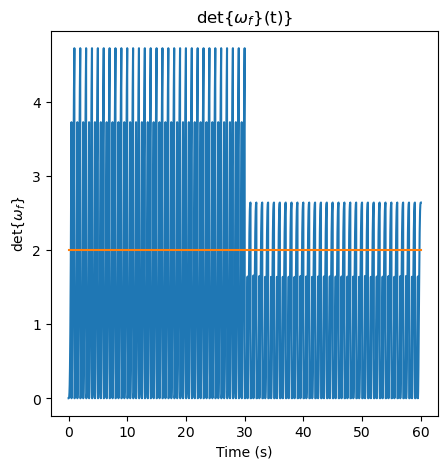

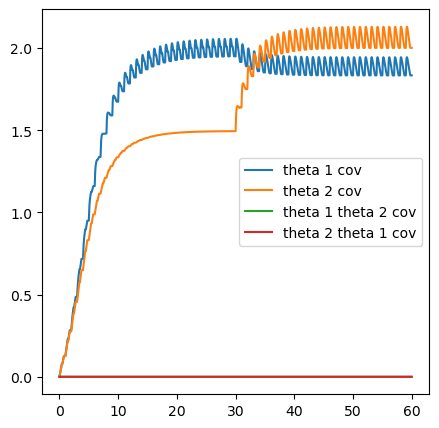

det_omega_f_thre: 3.0
Rnoise: 0.2


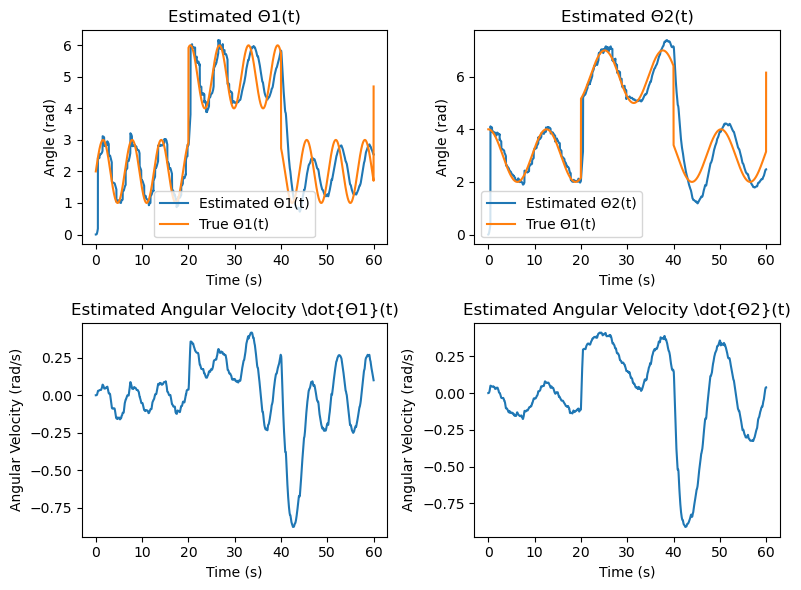

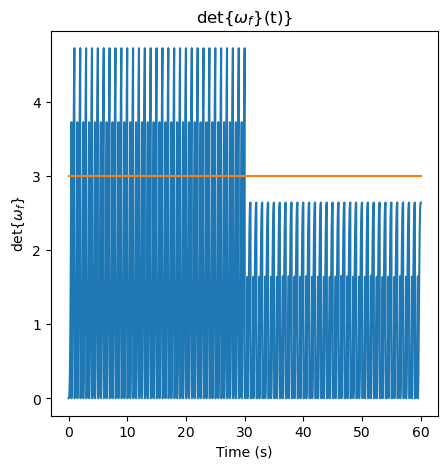

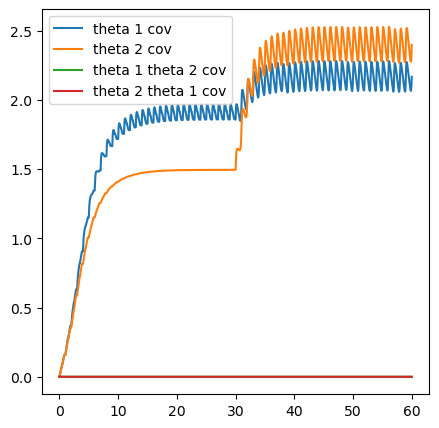

det_omega_f_thre: 2.0
Rnoise: 0.5


In [100]:

#    Rnoise = R*2.0
for Rnoise in Rnoise_list:
    for det_omega_f_thresh in  det_omega_f_thresh_list:
    #for det_omega_f_thresh in [ ] :
        print('det_omega_f_thre: ' + str(det_omega_f_thresh))
        print('Rnoise: ' + str(Rnoise))
    
        # Initialize arrays to store concatenated results
        x_sol_full = np.empty((n, 0))
        p_sol_full = np.empty((n*n, 0))
        omega_f_sol_full = np.empty((omega_f_dim, 0))
        t_sol_full = np.array([])
        
        # Initial conditions
        x0 = np.array([0, 0, 0, 0])  # Initial state [θ1, θ2, θ1_dot, θ2_dot]
        P0 = 1.0e-5*np.eye(4)  # Initial error covariance
        omega_f = np.zeros((filter_dim, filter_dim))
        y_f = np.zeros(filter_dim)
        epsilon_f = np.zeros(filter_dim)


    
       
        
        # Simulation
        current_x0 = np.concatenate([x0, P0.flatten(), omega_f.flatten(), y_f.flatten(), epsilon_f.flatten()])
        
        # Reset Period for filters
        T = 0.5
        noise_interval = 0.1
        noise_function = piecewise_constant_white_noise_generator(tf, noise_interval, Rnoise) # function of time t
        
        beta = 0.50 / T
        time_intervals = np.arange(t0, tf + T, T)  # Interval boundaries
        
        # The main loop iterate every T interval
        for i in range(len(time_intervals) - 1):
            # sol_temp = solve_ivp(kalman_filter, [t0, tf], current_x0, t_eval=t_eval, method='RK45', vectorized=True)
            t_span = [time_intervals[i], time_intervals[i+1]]
            Neval_temp = (t_span[1] - t_span[0]) * sample_hz + 1
            t_eval_temp = np.linspace(t_span[0], t_span[1], int(np.round(Neval_temp)))  # Time points to evaluate
        
            #############################
            # reset filter values
            current_x0[x_dim + p_dim : x_dim + p_dim + omega_f_dim + y_f_dim + epsilon_f_dim] = 0
            #############################
        
            sol_temp = solve_ivp(kalman_filter, t_span, current_x0, method='RK45', t_eval=t_eval_temp, vectorized=True)
        
            # Extract last state as initial state for next interval
            current_x0 = sol_temp.y[:, -1]
            
            # Store results
        
            if i == 0:
                x_sol_full =       np.hstack((x_sol_full, sol_temp.y[:x_dim, :]))
                p_sol_full =       np.hstack((p_sol_full, sol_temp.y[x_dim:x_dim + p_dim, :]))
                omega_f_sol_full = np.hstack((omega_f_sol_full, sol_temp.y[x_dim +p_dim : x_dim + p_dim + omega_f_dim , :]))
                t_sol_full =       np.hstack((t_sol_full, sol_temp.t))
            else:
                x_sol_full =       np.hstack((x_sol_full[:,:-1], sol_temp.y[ :x_dim, :]))
                p_sol_full =       np.hstack((p_sol_full[:,:-1], sol_temp.y[x_dim:x_dim + p_dim, :]))
                omega_f_sol_full = np.hstack((omega_f_sol_full[:,:-1], sol_temp.y[x_dim + p_dim : x_dim + p_dim + omega_f_dim , :]))
                t_sol_full =       np.hstack((t_sol_full[:-1],   sol_temp.t))
        
        

        
        sol = Sol(t_sol_full, np.vstack((x_sol_full, p_sol_full, omega_f_sol_full)), x_dim)
        
        # Extracting states and plotting
        x_est = sol.y[:x_dim].T
        theta1, theta2, theta_dot1, theta_dot2 = x_est[:, 0], x_est[:, 1], x_est[:, 2], x_est[:, 3]
        
        omega_f = sol.y[x_dim + p_dim : x_dim + p_dim + omega_f_dim].T
        def return_det(omega_f):
            out = scipy.linalg.det(omega_f.flatten().reshape(2,2))
            return out
        det_omega_f = np.apply_along_axis( return_det, 1, omega_f)
        
        # replicate true signal
        true_theta = true_signal(t_eval)
        true_theta1 = true_theta[0]
        true_theta2 = true_theta[1]
        
        ###############################
        # save sol
        ###############################
        dir_name = generate_dir(phi_freq_coeff, Rnoise, det_omega_f_thresh)
        Path(dir_name).mkdir(parents=True, exist_ok=True)
        save_sol(sol, dir_name)

        ###############################
        # Save figs
        ###############################
        plt.figure(figsize=(8, 6))
        plt.subplot(2, 2, 1)
        plt.plot(t_eval, theta1, label='Estimated Θ1(t)')
        plt.plot(t_eval, true_theta1, label='True Θ1(t)')
        plt.legend()
        plt.title('Estimated Θ1(t)')
        plt.xlabel('Time (s)')
        plt.ylabel('Angle (rad)')
        
        plt.subplot(2, 2, 2)
        plt.plot(t_eval, theta2, label='Estimated Θ2(t)')
        plt.plot(t_eval, true_theta2, label='True Θ1(t)')
        plt.legend()
        plt.title('Estimated Θ2(t)')
        plt.xlabel('Time (s)')
        plt.ylabel('Angle (rad)')
        
        plt.subplot(2, 2, 3)
        plt.plot(t_eval, theta_dot1, label='Estimated \dot{Θ1}(t)')
        plt.title('Estimated Angular Velocity \dot{Θ1}(t)')
        plt.xlabel('Time (s)')
        plt.ylabel('Angular Velocity (rad/s)')
        
        plt.subplot(2, 2, 4)
        plt.plot(t_eval, theta_dot2, label='Estimated \dot{Θ2}(t)')
        plt.title('Estimated Angular Velocity \dot{Θ2}(t)')
        plt.xlabel('Time (s)')
        plt.ylabel('Angular Velocity (rad/s)')
        
        plt.tight_layout()
        plt.savefig(dir_name + '/estimate.png')
        plt.show()


        
        
        plt.figure(figsize=(5,5))
        plt.plot(t_eval, det_omega_f, label='Determinent omega_f')
        plt.plot([t_eval[0], t_eval[-1]], [det_omega_f_thresh, det_omega_f_thresh], label='Det omega_f threshold')
        plt.title('det{$\omega_f$}(t)}')
        plt.xlabel('Time (s)')
        plt.ylabel('det{$\omega_f$}')
        plt.savefig(dir_name + '/det_omega.png')
        
        #####################################
        px1x1 = sol.y[x_dim]
        px1x2 = sol.y[x_dim+1]
        px2x2 = sol.y[x_dim+5]
        px2x1 = sol.y[x_dim+4]
        plt.figure(figsize=(5, 5))
        plt.plot(t_eval, px1x1, label='theta 1 cov')
        plt.plot(t_eval, px2x2, label='theta 2 cov')
        plt.plot(t_eval, px1x2, label='theta 1 theta 2 cov')
        plt.plot(t_eval, px2x1, label='theta 2 theta 1 cov')
        plt.legend()
        plt.savefig(dir_name + '/p_cov.png')
        plt.show()
    

    
       ####### Generate table 
        

In [91]:
# 平均と標準偏差
def measure_outlier_freq(est, true, dbgmsg=False, mode='zscore'):
    # Z score based measure of outlier
    # pm 3 is measured
    
    data = est - true
    mean = np.mean(data)
    std = np.std(data)
    
    if mode=='zscore':
        # Zスコアの計算
        z_scores = (data - mean) / std
        
        # 外れ値の識別 (ここではZスコアが3以上または-3以下を外れ値とする)
        outlier_mask = (z_scores > 3) | (z_scores < -3)
        outliers = data[outlier_mask]
        
        # 外れ値の割合
        outlier_fraction = len(outliers) / len(data)
    
    elif mode=='fixed':
        # set fixed threshold value
        fixed_thre = 0.5
        outlier_mask = (data > fixed_thre) | (data < -fixed_thre)
        outliers = data[outlier_mask]
        # 外れ値の割合
        outlier_fraction = len(outliers) / len(data)
    else:
        # not defined
        return -1

    if dbgmsg == True:
        print("外れ値:", outliers)
        print("外れ値の割合:", outlier_fraction)

    return outlier_fraction


In [92]:
import pandas as pd
import seaborn as sns
import sklearn.metrics


results = []
Rnoise_list =  [R*0.2, R*0.5, R*1.0, R*2.0, R*3.0]
#det_omega_f_thresh_list = [0.000001, 0.1, 0.5, 1.0, 1.5, 2.50, np.infty ]
det_omega_f_thresh_list = [0.000001, 0.001, 0.01,  0.1, 0.5, 1.0, 1.5, 2.0, 3.0, np.infty ]

for Rnoise in Rnoise_list:
    for det_omega_f_thresh in det_omega_f_thresh_list:
        # fetch sol
        dir_name = generate_dir(phi_freq_coeff, Rnoise, det_omega_f_thresh)

        sol = read_sol(dir_name)
        theta1, theta2, theta_dot1, theta_dot2 = sol.fetch_est()
        true_theta = true_signal(t_eval)
        true_theta1 = true_theta[0]
        true_theta2 = true_theta[1]
 
        # MSE
        mse1 = sklearn.metrics.mean_squared_error(theta1, true_theta1)
        mse2 = sklearn.metrics.mean_squared_error(theta2, true_theta2)
        mse_ave = (mse1 + mse2) / 2

        # Z score based outlier measure for pm 3
        zol1 = measure_outlier_freq(theta1, true_theta1)
        zol2 = measure_outlier_freq(theta2, true_theta2)
        zol_ave = (zol1 + zol2) / 2

        # Fixed value (threshold=0.2) based outlier measure 
        fol1 = measure_outlier_freq(theta1, true_theta1, mode='fixed')
        fol2 = measure_outlier_freq(theta2, true_theta2, mode='fixed')
        fol_ave = (fol1 + fol2) / 2       
        results.append({'NOISEVAR': Rnoise, 'OMEGA_THRE': det_omega_f_thresh, 'MSE': mse_ave, 'ZOL': zol_ave, 'FOL': fol_ave})

# DataFrameの作成
df = pd.DataFrame(results)

# CSVファイルに保存
df.to_csv('result/experiment_results.csv', index=False)


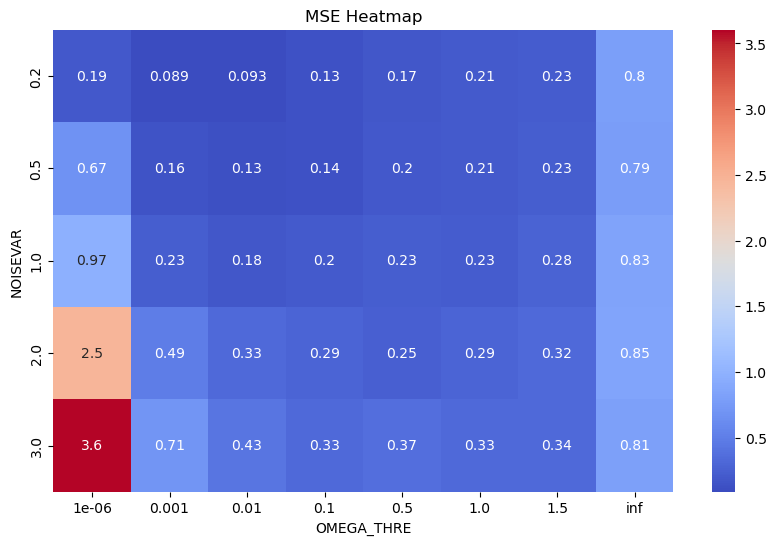

In [93]:
# ピボットテーブルの生成
pivot_table = df.pivot_table(index='NOISEVAR', columns='OMEGA_THRE', values='MSE', aggfunc=np.sum)

# ヒートマップのプロット
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, cmap='coolwarm')
plt.title('MSE Heatmap')
plt.show()

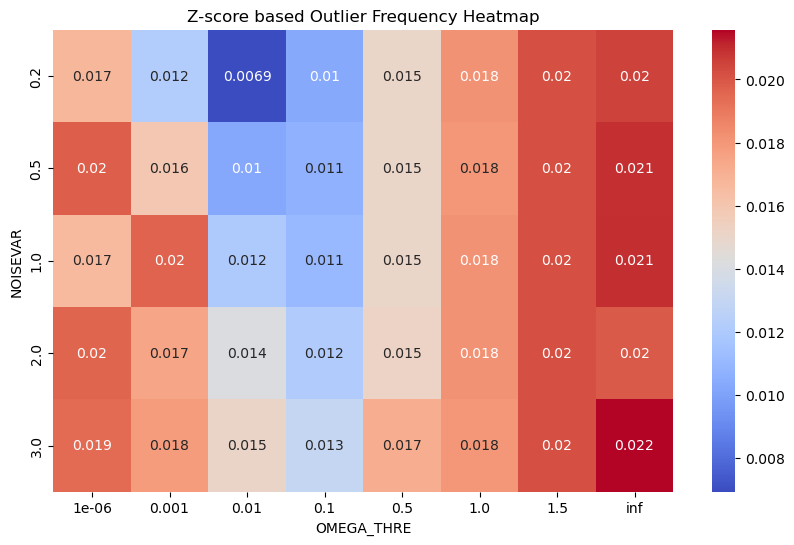

In [94]:
# ピボットテーブルの生成
pivot_table = df.pivot_table(index='NOISEVAR', columns='OMEGA_THRE', values='ZOL', aggfunc=np.sum)

# ヒートマップのプロット
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, cmap='coolwarm')
plt.title('Z-score based Outlier Frequency Heatmap')
plt.show()

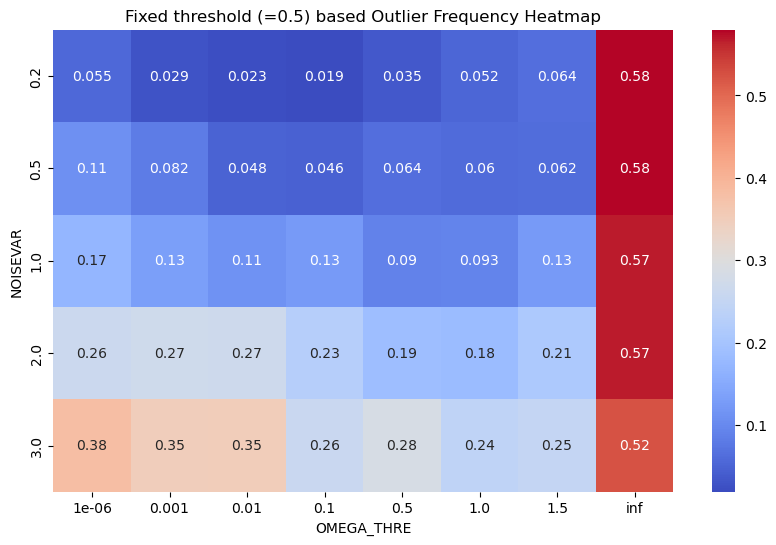

In [96]:
# ピボットテーブルの生成
pivot_table = df.pivot_table(index='NOISEVAR', columns='OMEGA_THRE', values='FOL', aggfunc=np.sum)

# ヒートマップのプロット
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, cmap='coolwarm')
plt.title('Fixed threshold (=0.5) based Outlier Frequency Heatmap')
plt.show()

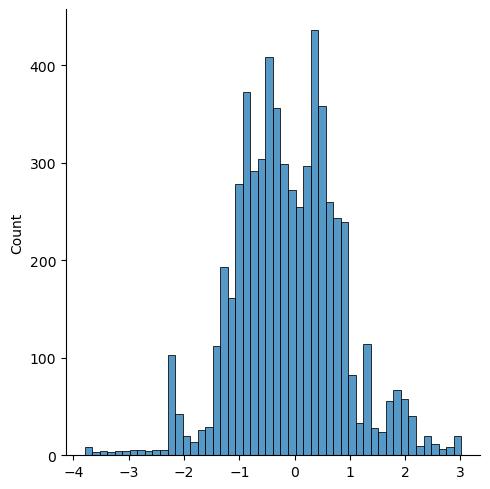

In [57]:
# distribution plot of error 
sns.displot(theta1 - true_theta1)

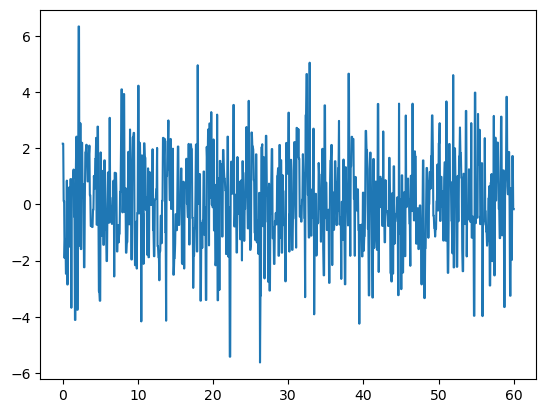

In [97]:
# noise profile
t_noise = np.linspace(0, 60, 1000)

noise_function = piecewise_constant_white_noise_generator(tf, noise_interval, Rnoise) # function of time t
noise = np.array( [noise_function(item) for item in t_noise])
plt.plot(t_noise, noise)

(array([0.00000000e+00, 1.64255934e-06, 1.68885640e-05, ...,
        2.20493146e+00, 2.19025042e+00, 2.18415397e+00]),
 array([0.00000000e+00, 5.17257853e-04, 2.02519487e-03, ...,
        2.15827236e+00, 2.14665998e+00, 2.14134918e+00]),
 array([0.00000000e+00, 1.44051719e-08, 3.17815025e-07, ...,
        2.66249408e-02, 2.12386860e-02, 1.89659078e-02]),
 array([ 0.00000000e+00,  1.73089794e-06,  1.35195277e-05, ...,
        -8.12503358e-03, -1.21820046e-02, -1.40072097e-02]))